
# Data Mining Techniques - Movie Recommendation System

## 0. Import libraries and load the necessairy datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from google.colab import drive


warnings.filterwarnings('ignore')  # Ignore warnings

# IMPORTANT: If you want to import from drive, set this to "True".
import_from_drive = True

if import_from_drive:
  drive.mount('/content/drive')
  nx_t = 'netflix_titles.csv'
  imdb_m = 'IMDb movies.csv'
  imdb_r = 'IMDb ratings.csv'
  at = r'/content/drive/MyDrive/Colab Notebooks/webMining/Movie-Recommendation-System-main/data/'
else:
  at = 'YOUR-LINK-GOES-HERE'
  nx_t = 'netflix_titles.csv'
  imdb_m = 'IMDb_movies.csv'
  imdb_r = 'IMDb_ratings.csv'

# Netflix titles
nx_df = pd.read_csv(at + nx_t)

# IMDb movies
imdb_m_df = pd.read_csv(at + imdb_m)

# IMDb ratings
imdb_r_df = pd.read_csv(at + imdb_r)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Missing data handling

By observing the `netflix_titles` dataset, the **director, cast** and **country** columns are quite lacking in information and as a result, the answers to the required questions do not take advantage of the full amount of information provided. The following code cell fills a set of missing fields in the `netflix_titles` dataset with the corresponding `IMDb_movies` filled fields located in the **director, cast** and **country** columns.  

In [4]:
# Data Preparation
#------------------

# Perform left join => [nx_df OUTER LEFT JOIN imdb_m_df]
nx_df = nx_df.merge(imdb_m_df, on='title', how='left', suffixes=('', '_y'))

# Drop any duplicate from the join
nx_df = nx_df.drop_duplicates(subset='show_id').reset_index(drop=True)

# Find any NaN cell from nx_df and replace it with the respective imdb_m_df value
nx_df['director'][nx_df['director'].isnull()] = nx_df['director_y']
nx_df['cast'][nx_df['cast'].isnull()] = nx_df['actors']
nx_df['country'][nx_df['country'].isnull()] = nx_df['country_y']

# Form the appropriate column list to drop from nx_df
imdb_cols = imdb_m_df.columns.to_list()
[imdb_cols.remove(c) for c in ['title', 'country', 'director', 'duration', 'description']]
[imdb_cols.append(c) for c in ['country_y', 'director_y', 'duration_y', 'description_y']]

# Remove any unecessairy column 
nx_df.drop(columns=imdb_cols, inplace=True)

## 1. Queries

### Query 1.
*Which of the following is numerically superior, movies or TV shows?*

There are more existing movies than TV shows!
Movies: 5377 | TV Shows: 2410


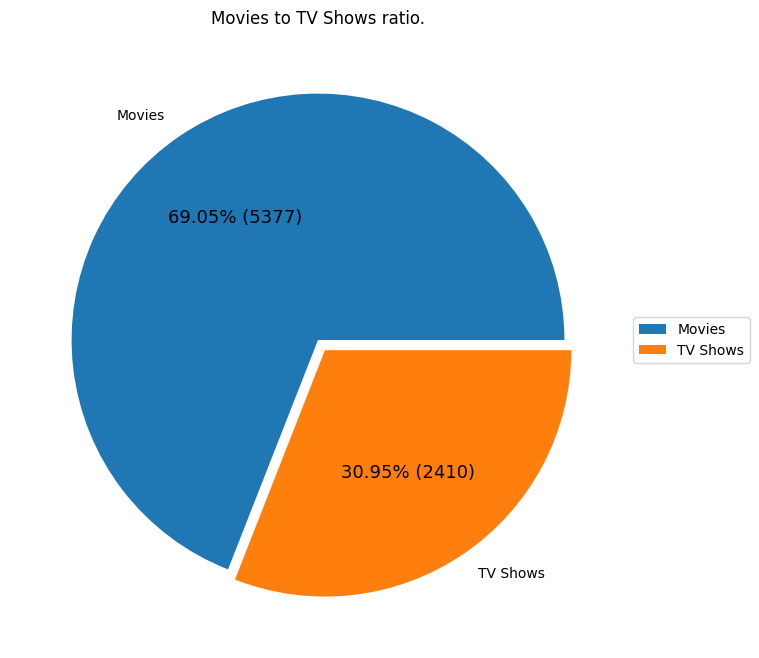

In [5]:
''' 
In the netflix dataset, there exist either movies 
or shows, so if we find the total number of movies, we 
can automatically compute the number of TV Shows, since the 
total row number is being stored in pandas.DataFrame.
'''

# Get the total number of movies
total_movies = nx_df['type'].where(nx_df['type'] == 'Movie').count()
# Get the total number of rows
total_rows = nx_df.index.stop

# If the total number of movies is greater than the half
# dataframe's rows, movies are more
if total_movies > total_rows // 2:
    print('There are more existing movies than TV shows!') 
# If the total number of movies is less than the half
# dataframe's rows, TV shows are more
elif total_movies < total_rows // 2:
    print('There are more existing TV shows than movies!')
# Otherwise, movies are equal to TV shows
else:
    print('TV series and movies are equal!')
print(f'Movies: {total_movies} | TV Shows: {total_rows - total_movies}')

# Draw a pie plot to display the results
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = plt.pie(x=[total_movies, total_rows - total_movies], labels=['Movies', 'TV Shows'], 
        explode=(0, 0.05), autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, (p/100)*total_rows))

ax.legend(wedges, ['Movies', 'TV Shows'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=13)

ax.set_title("Movies to TV Shows ratio.")

plt.show()

### Query 2.
*Has Netflix invested more in movies or TV series in recent years?*

We interpret the term "invest" based on the annual addition of new content (movies or series).

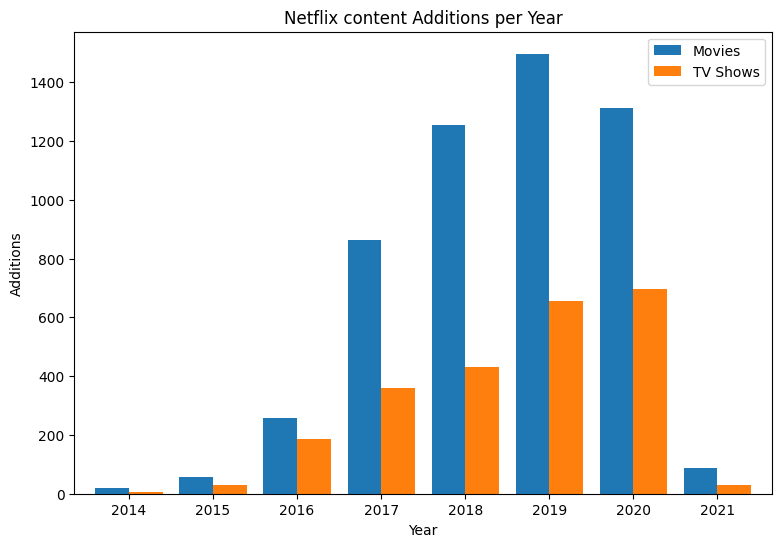

In [6]:
def get_info2(nx_df, title):  # title is either 'Movie' or 'TV Show'

  # Get titles and date added
  info = nx_df[['type', 'date_added']].where(nx_df['type'] == title).dropna()
  
  # Replace 'date_added' field with *year* added
  info['date_added'] = info.apply(lambda row : str(row.date_added)[-4:], axis=1)
  info = info.groupby(by=['date_added']).count()
  info.rename({'type' : (title +'s')}, axis=1, inplace=True)
  return info


def content_additions(latest_years_to_show = 8):
  movie_info = get_info2(nx_df, 'Movie')
  show_info = get_info2(nx_df, 'TV Show')

  # Concatenate Movies and Shows per year, and fill NaN with 0, indicating years without Movies or Series.
  total_info = pd.concat([movie_info, show_info], axis=1).fillna(0)
  total_info[['Movies', 'TV Shows']] = total_info[['Movies', 'TV Shows']].astype(int)

  total_info.tail(latest_years_to_show).plot(kind='bar', legend=True, width=0.8, xlabel='Year', 
              ylabel='Additions', title='Netflix content Additions per Year', figsize = (9, 6))
  plt.xticks(rotation=0)
  plt.show()

content_additions()

Viewing the graph and based on the metrics we set, it is also clear that Netflix invests more in movies. Especially, during the years 2017, 2018 and 2019, at least twice as many movies were added compared to series on the platform.

### Query 3.
*Which country has the most content?*

Country with the most content is United States, having produced 3297 movies and tv shows.


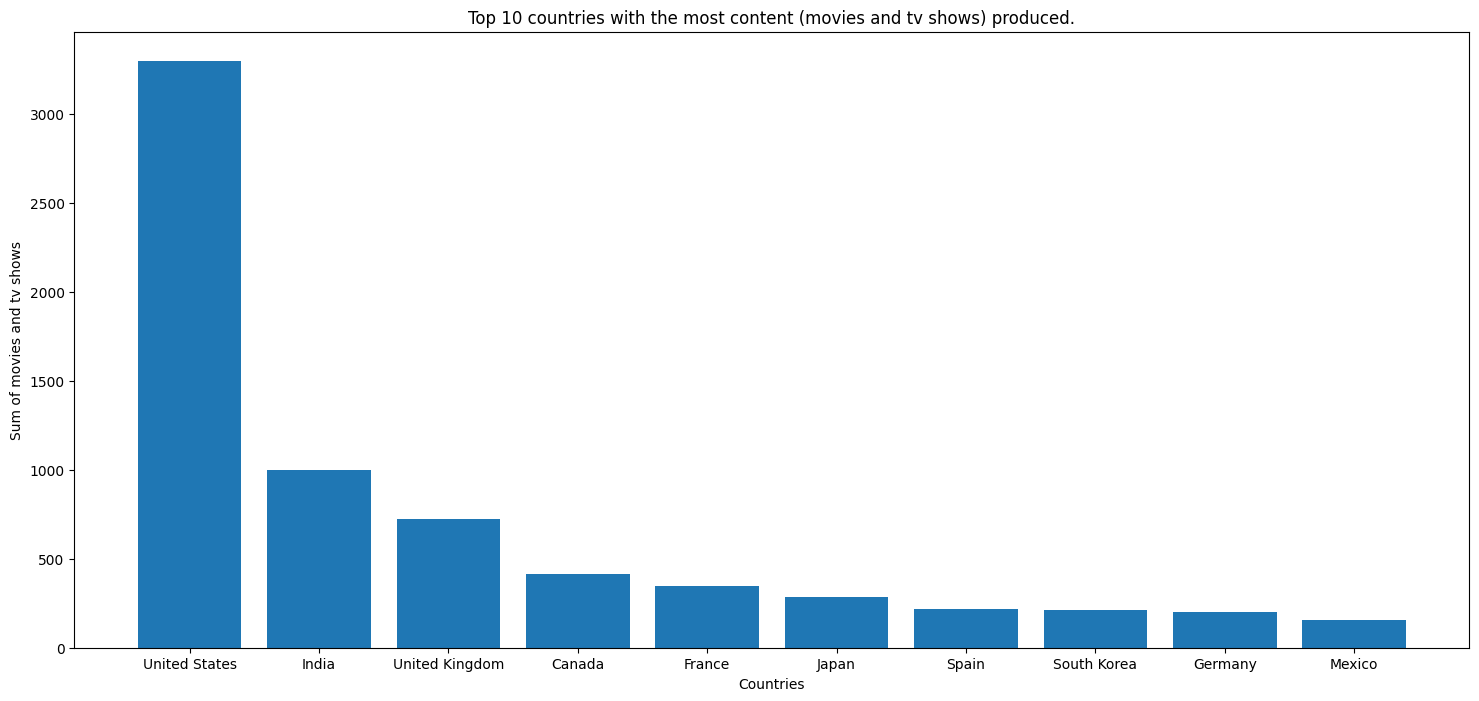

In [7]:
'''
Store all participating countries in a dictionary
and save the number of productions of each country.
e.g: {Greece: 15, France: 26, Russia: 45}
'''
def countries_content(df, countries={}):
    # For each row
    for producers in df['country'].dropna():
        # Split the row into multiple countries (if necessary)
        for country in str(producers).strip().split(','):
            c = country.strip()
            # Store each country in the dictionary
            countries[c] = 1 if c not in countries else countries[c] + 1
    return countries

countries = countries_content(nx_df)
# The country with the most content is simply the max of the countries' dictionary
win_countr = max(countries, key=countries.get)

print(f'Country with the most content is {win_countr}, having produced {countries[win_countr]} movies and tv shows.')

# Sort the countries and draw a bar plot for demonstration purposes
countries = dict(sorted(countries.items(), key=lambda item: item[1], reverse=True))

topn = 10
fig, ax = plt.subplots(1, 1, figsize=[18, 8])
plt.bar(x=[i for j,i in enumerate(countries) if j < topn], height=[countries[i] for j,i in enumerate(countries) if j < topn])
ax.set_title(f'Top {topn} countries with the most content (movies and tv shows) produced.')
ax.set_xlabel('Countries')
ax.set_ylabel('Sum of movies and tv shows')
plt.show()

### Query 4.
*What kind of content does each country have?*

We interpret the content as "Movies" or "TV Series". As country's content, we consider the films and series that were shot entirely or partially in that country (that is, the country exists in the 'country' field of production).

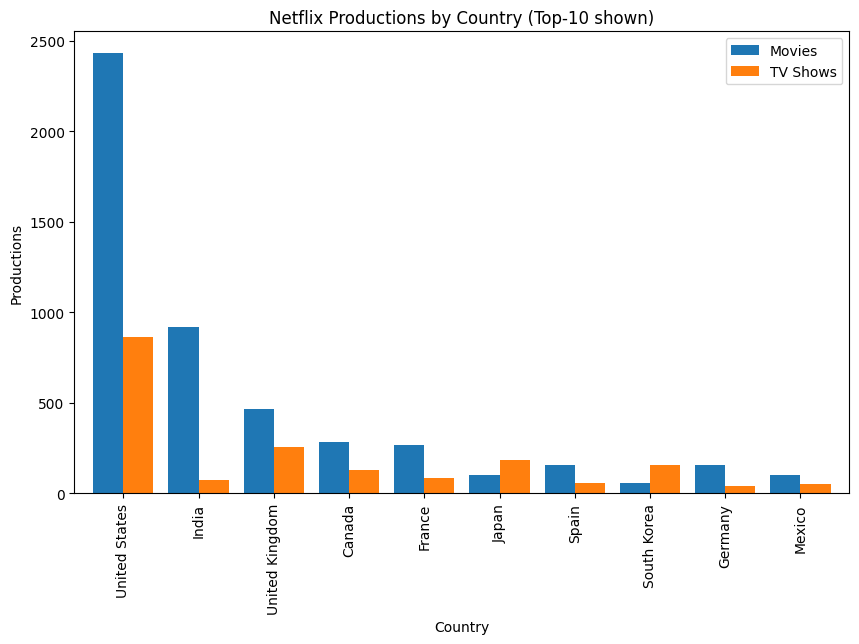

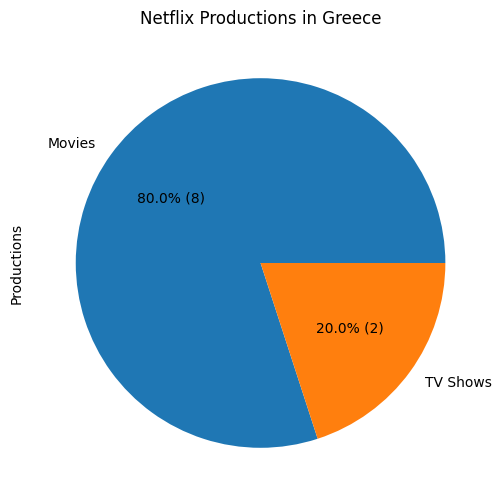

In [8]:
def get_info4(nx_df, title):  # title is either 'Movie' or 'TV Show'
  # Get types of content and countries of production 
  info = nx_df[['type', 'country']].where(nx_df['type'] == title).dropna()
  # Create new rows, each having exactly 1 country (by splitting multi-country productions)
  info['country'] = info['country'].str.strip().str.split(',')
  info = info.explode('country')
  info['country'] = info['country'].str.strip()
  info = info.explode('country')
  info = info.groupby(by=['country']).count()
  info.rename({'type' : (title + 's')}, axis=1, inplace=True)
  return info


def content_per_country():
  movie_info = get_info4(nx_df, 'Movie')
  show_info = get_info4(nx_df, 'TV Show')

  # Concatenate Movies and Shows per country, and fill NaN with 0, 
  # indicating countries without Movies or Series produced
  total_info = pd.concat([movie_info, show_info], axis=1).fillna(0)
  total_info[['Movies', 'TV Shows']] = total_info[['Movies', 'TV Shows']].astype(int)
  # Sort countries by most productions
  total_info = total_info.assign(f = total_info['Movies'] + 
              total_info['TV Shows']).sort_values('f', ascending=False).drop('f', axis=1)

  def plot_content_by_country(info, topk = 10, country = None):
    if country is not None and country in info.index:
      total_prod = info.loc[country]['Movies'] + info.loc[country]['TV Shows']
      info.loc[country].plot(kind='pie', figsize = (6, 6), autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_prod),
                          title=f'Netflix Productions in {country}', ylabel='Productions')
    else:
      info.head(topk).plot(kind='bar', legend=True, width=0.8, xlabel='Country', figsize = (10, 6),
                          ylabel='Productions', title=f'Netflix Productions by Country (Top-{topk} shown)')
    plt.show()
    print()

  plot_content_by_country(total_info, topk=10)
  plot_content_by_country(total_info, country='Greece')

content_per_country()

Some interesting facts that can be extracted from the data are:
* The vastly larger movie production than series in **India**.
* The production of more series than movies in **Japan** and **South Korea**, possibly related to their close geographical location on the Asian continent.

### Query 5.
*Display graphs showing the actors with the most movies in each country. Do the same for TV series.*

In [9]:
'''
Utility function that:
> Explodes a specific column's fields to multiple individual rows
> Cleans any whitespace and '\n' from a specific column's fields  
'''
def clean_explode(df, column):
    df[column] = df[column].str.strip().str.split(',')
    df = df.explode(column)
    df[column] = df[column].apply(lambda x: str(x).strip())
    df = df.reset_index(drop=True)
    return df

'''
Computes and plots the actors that took place to the most productions 
(movies and tv shows seperately) in every dataset's existing country
'''
def actors_per_country(info, ptype='movie'):

    # Explode properly all the necessary fields
    info = clean_explode(info, 'cast')
    info = clean_explode(info, 'country')
    
    # Group by country and cast and count all the productions 
    results = pd.DataFrame(info.groupby(by=['country', 'cast']).count()).reset_index()
    results.columns = ['country', 'actors', 'num_of_mov_part']

    # More data cleaning
    results = results.replace(to_replace='', value=float('NaN'))
    results.dropna(inplace=True)

    # For every unique country
    countries = {}
    for country in results['country'].unique():
        if country not in countries:
            countries[country] = 1

            # Create a new dataframe consisting of all the current country's 
            # actors and their summed up productions
            country_df = pd.DataFrame(results[results['country'] == country])
            country_df = country_df.sort_values(by='num_of_mov_part', ascending=False)
            
            # Plot the results (top N)
            topn = 10
            country_df.head(topn).plot(x='actors', y='num_of_mov_part', kind='bar', width=0.3, xlabel='Actors', legend=False,
                    ylabel=f'Total {ptype}s', title=f'Top {topn} actors with the highest {ptype} participation in {country}.', figsize=[18, 6])         

            plt.xticks(rotation=20)
            plt.show()

# Extract only the desired columns
info = nx_df[['type', 'country', 'cast', 'show_id']]
# Drop NaNs
info.dropna(inplace=True)
info = info.reset_index(drop=True)

# Divide the initial dataset into two seperate ones (Movies and TV Shows)
info_mov = info[info['type'] == 'Movie'].reset_index(drop=True)
info_tv = info[info['type'] == 'TV Show'].reset_index(drop=True)

actors_per_country(info_mov.drop(columns='type'))
actors_per_country(info_tv.drop(columns='type'), 'TV show')

Output hidden; open in https://colab.research.google.com to view.

### Query 6.

*Netflix claims to provide rich content for all ages. Is this true? Make a graph that sums up the number of movies according to the suggested age (referred to the rating column). The limits are determined according to the following table. Do the same for the rows.*

Little Kids  | Older Kids | Teens | Mature 
-------------|---------------|-----------|---------
G, TV-Y, TV-G | PG, TV-Y7, TV-Y7-FV, TV-PG | PG-13, TV-14 | R,NC-17, TV-MA


In [10]:
def map_rating_to_age(rating):
  ages = { 'Little Kids' : ['G', 'TV-Y', 'TV-G'],
           'Older Kids' : ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG'],
           'Teens' : ['PG-13', 'TV-14'],
           'Mature' : ['R', 'NC-17', 'TV-MA'] }
  for age in ages.keys():
    if rating in ages[age]:
      return age
  return ''

def get_info6(nx_df, title):
  info = nx_df[['type', 'rating']].where(nx_df['type'] == title).dropna()
  # Create new rows, each having exactly 1 rating (by splitting multi-rating productions)
  info['rating'] = info['rating'].str.strip().str.split(',')
  info = info.explode('rating')
  # Convert ratings to Group Age (Little Kids, Teens, etc)
  info['rating'] = info.apply(lambda row : map_rating_to_age(row.rating), axis=1)
  # Rule out Ratings that don't have a match to a Group Age based on the age array
  info = info[ info['rating'] != '' ]
  info = info.groupby(by=['rating']).count().reset_index()
  info = info.rename({'type' : (title + 's'), 'rating' : 'Rating'}, axis=1)
  info = info.sort_values(by=[title + 's'], ascending=False).set_index('Rating')
  return info

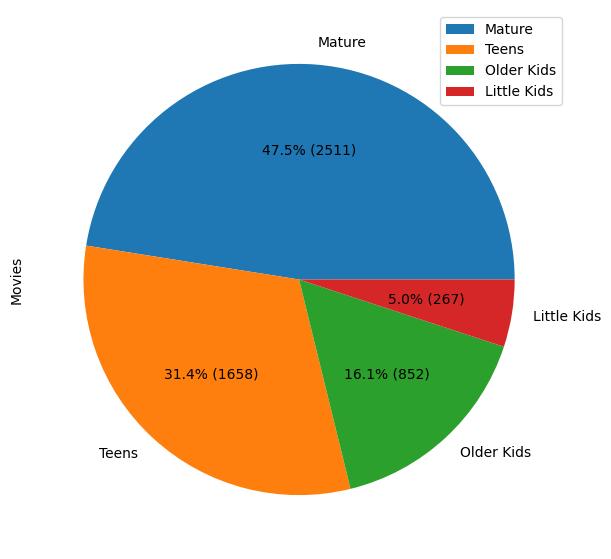

In [11]:
def rating_among_movies():
  movie_info = get_info6(nx_df, 'Movie')
  total_movies = movie_info['Movies'].sum()
  movie_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_movies))
  plt.show()

rating_among_movies()

Based on the Dataset we study, we notice that Netflix's claim is not true. Specifically, we observe that the majority of the films are destined for **Mature** audiences, followed by the age of **Teens** and followed by the  **Older Kids** and lastly **Little Kids**. Also, the graph shows that there's a huge gap between the first 2 and the last 2 age groups. We notice that the number of films provided is not evenly distributed among the age groups, but scales according to age, in favor of the older ones.

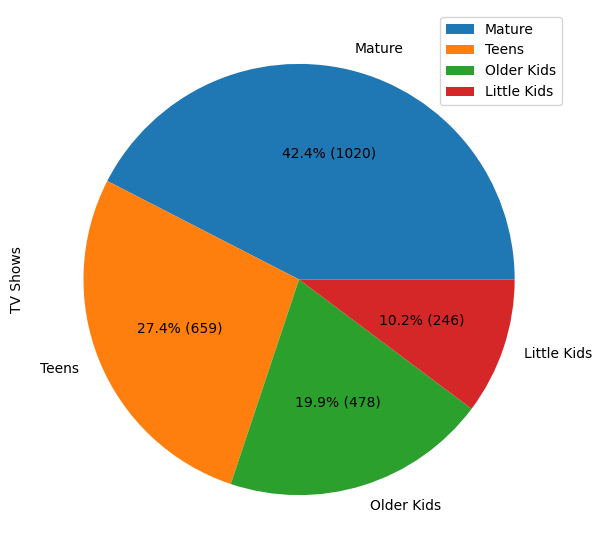

In [12]:
def rating_among_shows():
  show_info = get_info6(nx_df, 'TV Show')
  total_series = show_info['TV Shows'].sum()
  show_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_series))
  plt.show()

rating_among_shows()

Studying the Netflix TV series, we draw similar conclusions considering the distribution of movies by age group. However, we notice that the difference between the age groups is smaller than the one of the movies; thus, there are more series for "younger" ages than movies (%).

### Query 7.
*If a producer aims to have a high audience, he may think that it may be better to release his film at a season when there is no competition. Draw a graph representing the new content added per month, in order to help him choose the right time period.*

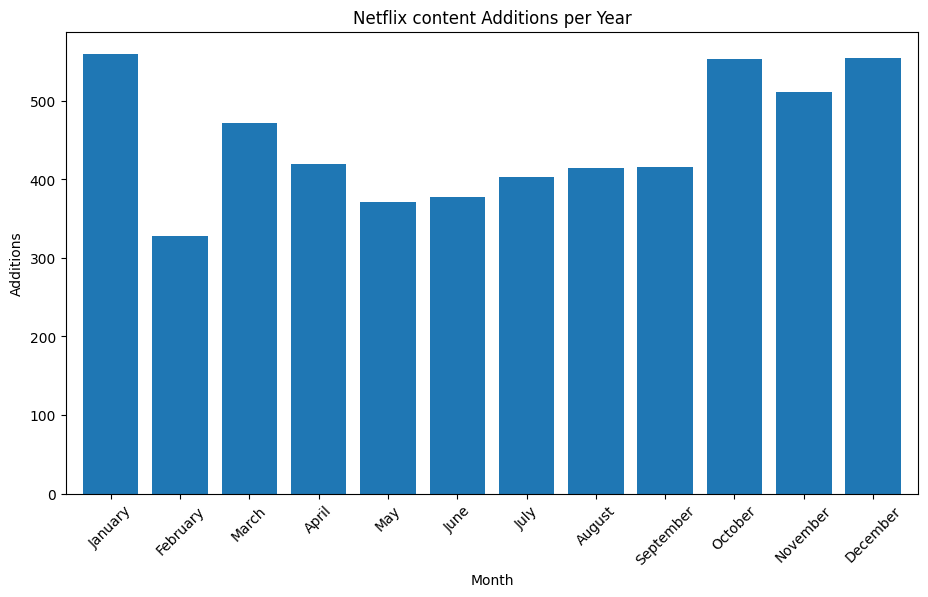

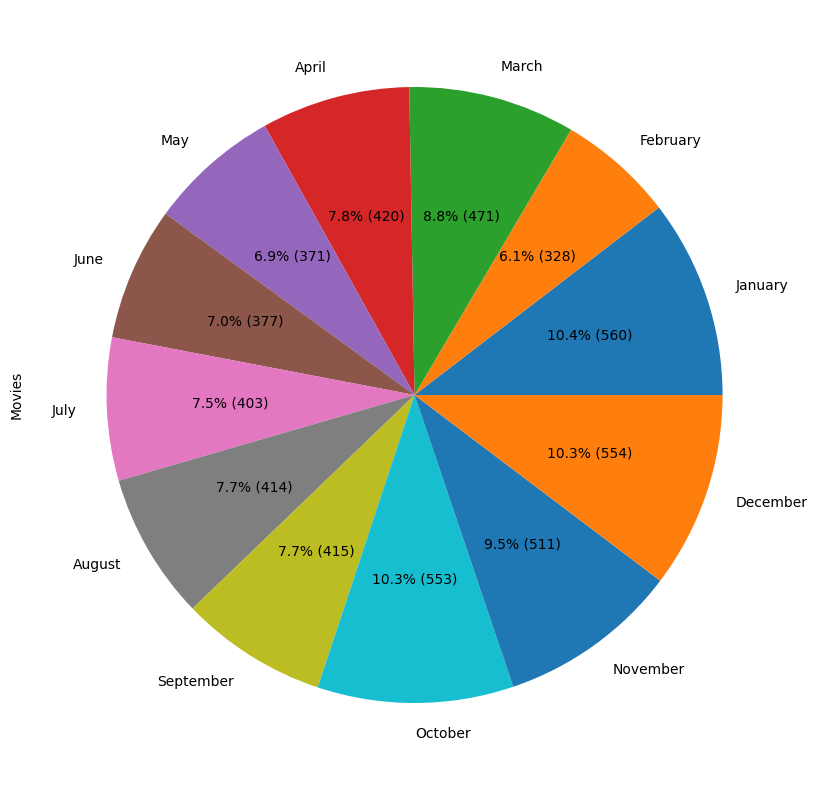

In [13]:
def get_info7(nx_df, title):  # title is either 'Movie' or 'TV Show'
  # Get titles and date added
  info = nx_df[['type', 'date_added']].where(nx_df['type'] == title).dropna()
  # Replace 'date_added' field with *month* added
  info['date_added'] = info.apply(lambda row : str(row.date_added).split()[0], axis=1)
  info = info.groupby(by=['date_added']).count().reset_index()
  info.rename({'type' : (title +'s')}, axis=1, inplace=True)
  # Convert 'date_added' to Categorical column so we can sort by month
  info['date_added'] = pd.Categorical(info['date_added'], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
  info = info.sort_values('date_added').set_index('date_added')
  return info


def content_additions_per_month():
  movie_info = get_info7(nx_df, 'Movie')
  movie_info.plot(kind='bar', legend=False, width=0.8, xlabel='Month',
              ylabel='Additions', title='Netflix content Additions per Year', figsize = (11, 6))
  plt.xticks(rotation=45)
  plt.show()
  print()
  total_movies = movie_info['Movies'].sum()
  movie_info.plot(kind = 'pie', subplots=True, figsize = (10, 10), legend=False,
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_movies))
  plt.show()

content_additions_per_month()

We notice that the most content is added in the period October-January (10% of the films each month), while the least is released in February (6.1%) followed by May (6.9%). Therefore, it would be more profitable for the producer to release his film on Netflix in February.

### Query 8.
*Draw a graph that summarizes the types of content (referred to the `listed_in` column).*


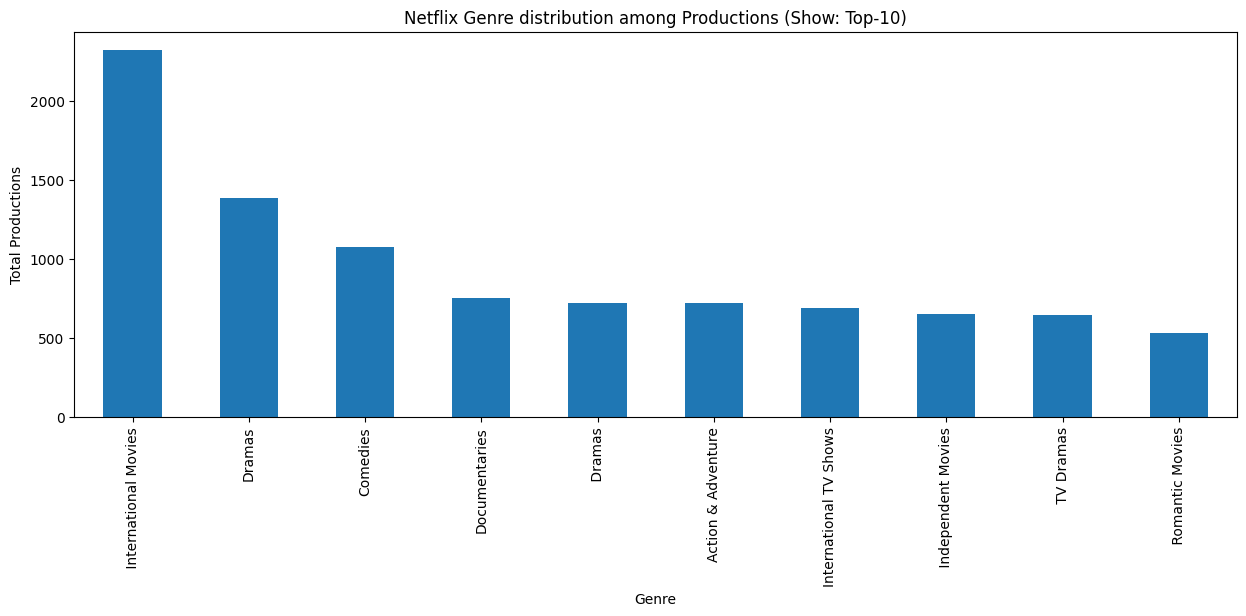

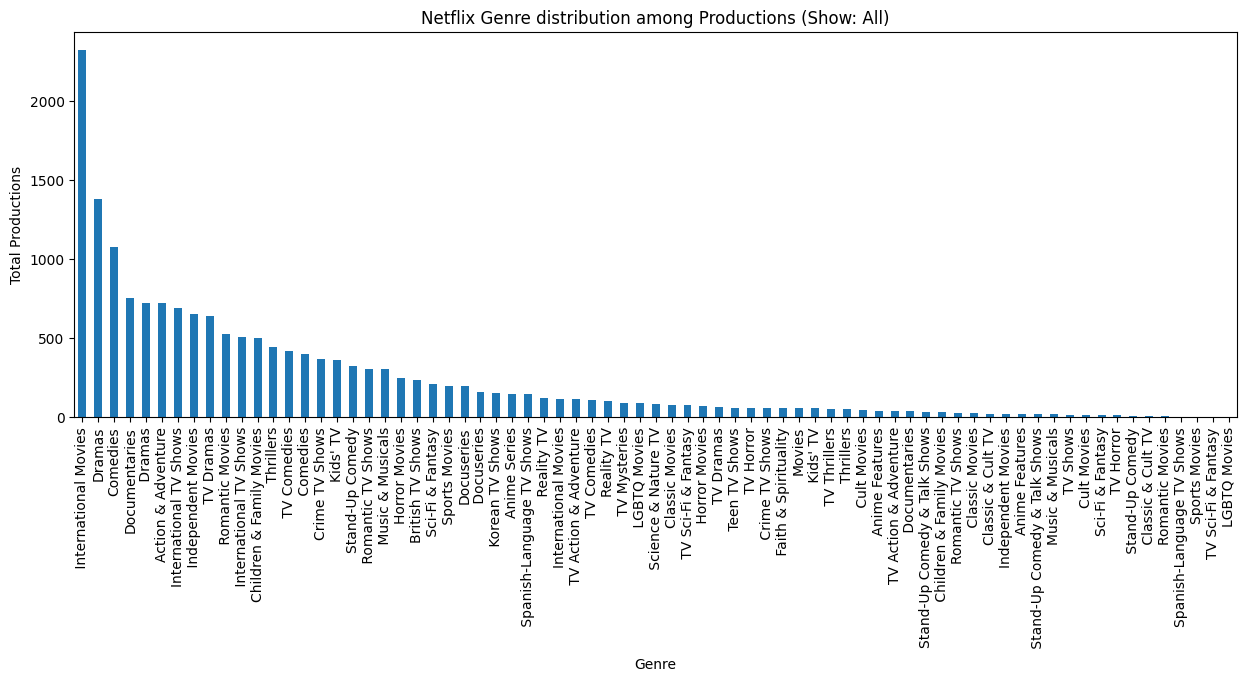

In [14]:
def get_genre_stats(topk = 8):
  genre_info = nx_df[['listed_in']].dropna().rename({'listed_in' : 'Genre'}, axis=1)
  # Create new rows, each having exactly 1 genre (by splitting multi-genre productions)
  genre_info['Genre'] = genre_info['Genre'].str.strip().str.split(',')
  genre_info = genre_info.explode('Genre')
  genre_info = genre_info.explode('Genre').reset_index()
  genre_info = genre_info.groupby(by=['Genre']).count()
  genre_info.rename({'index' : 'Count'}, axis=1, inplace=True)
  genre_info = genre_info.sort_values(by=['Count'], ascending=False)

  def plot_topk_genre(info, topk):
    desc = f'(Show: Top-{topk})'
    if topk == len(genre_info.index):
      desc = '(Show: All)'
    genre_info.head(topk).plot(kind='bar', width=0.5, xlabel='Genre', legend=False, figsize = (15,5),
                          ylabel='Total Productions', title=f'Netflix Genre distribution among Productions {desc}')
    plt.show()
    print()

  plot_topk_genre(genre_info, topk)
  plot_topk_genre(genre_info, genre_info.size)

get_genre_stats(topk = 10)

We notice that the genre with the most content (with a difference of almost 1000 producers compared to the 2nd) is **International Movies**, perhaps indicative of the spread and use of Netflix worldwide.

### Query 9.
*Observe the number of directors per country and present relevant graphs.*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'India'),
  Text(2, 0, 'United Kingdom'),
  Text(3, 0, 'Canada'),
  Text(4, 0, 'France'),
  Text(5, 0, 'Japan'),
  Text(6, 0, 'Spain'),
  Text(7, 0, 'South Korea'),
  Text(8, 0, 'Germany'),
  Text(9, 0, 'Mexico'),
  Text(10, 0, 'China'),
  Text(11, 0, 'Australia'),
  Text(12, 0, 'Egypt'),
  Text(13, 0, 'Turkey'),
  Text(14, 0, 'Hong Kong'),
  Text(15, 0, 'Italy'),
  Text(16, 0, 'Brazil'),
  Text(17, 0, 'Taiwan'),
  Text(18, 0, 'Belgium'),
  Text(19, 0, 'Argentina')])

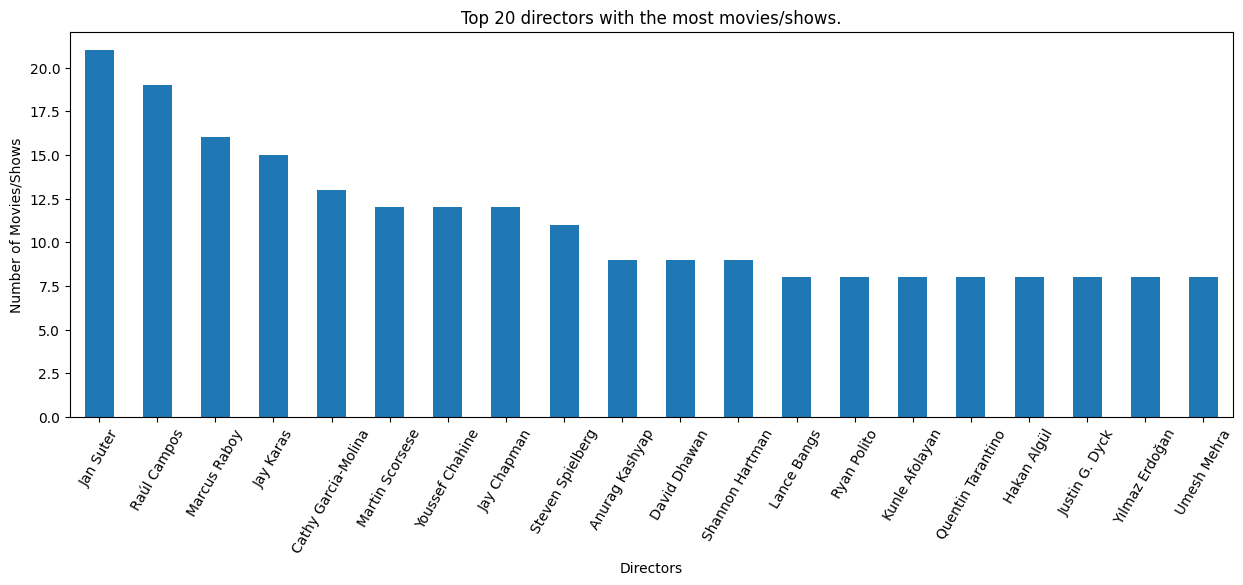

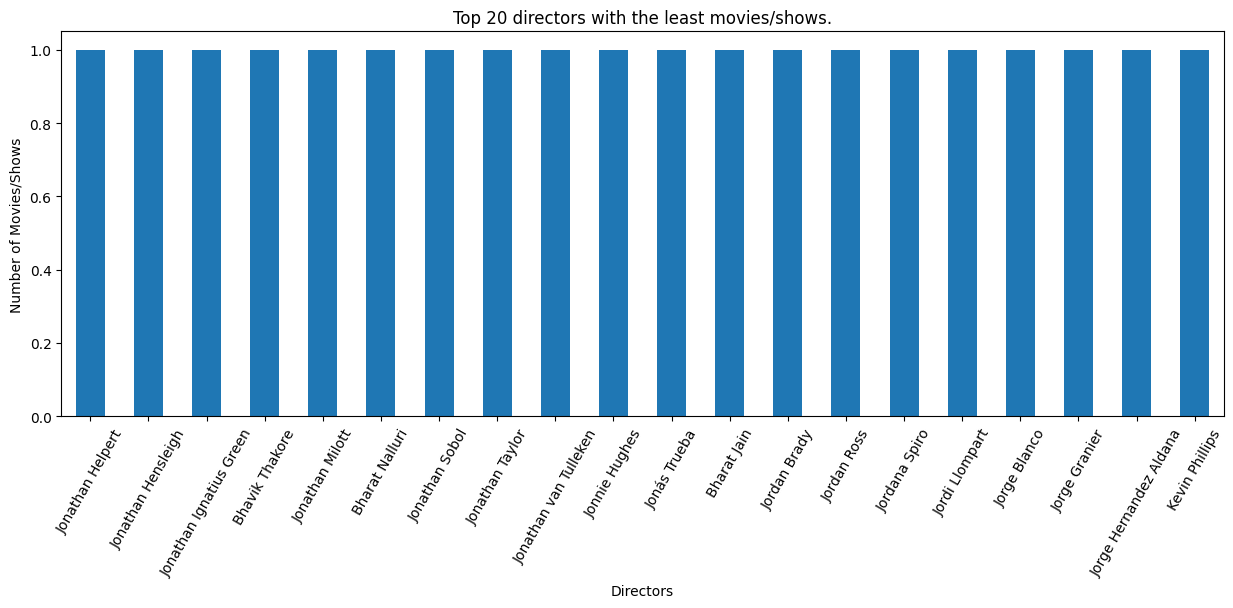

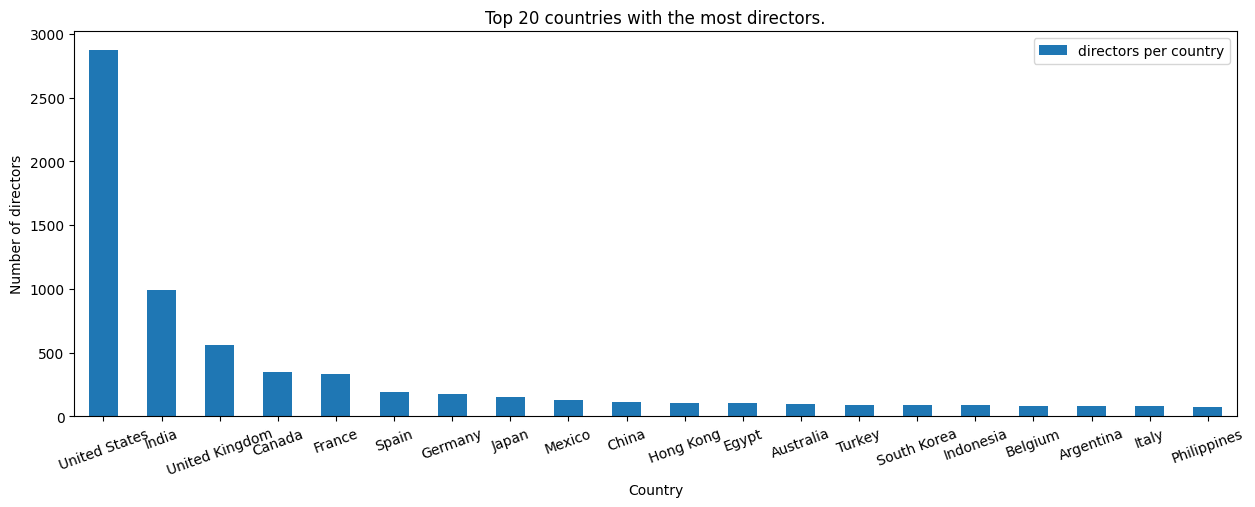

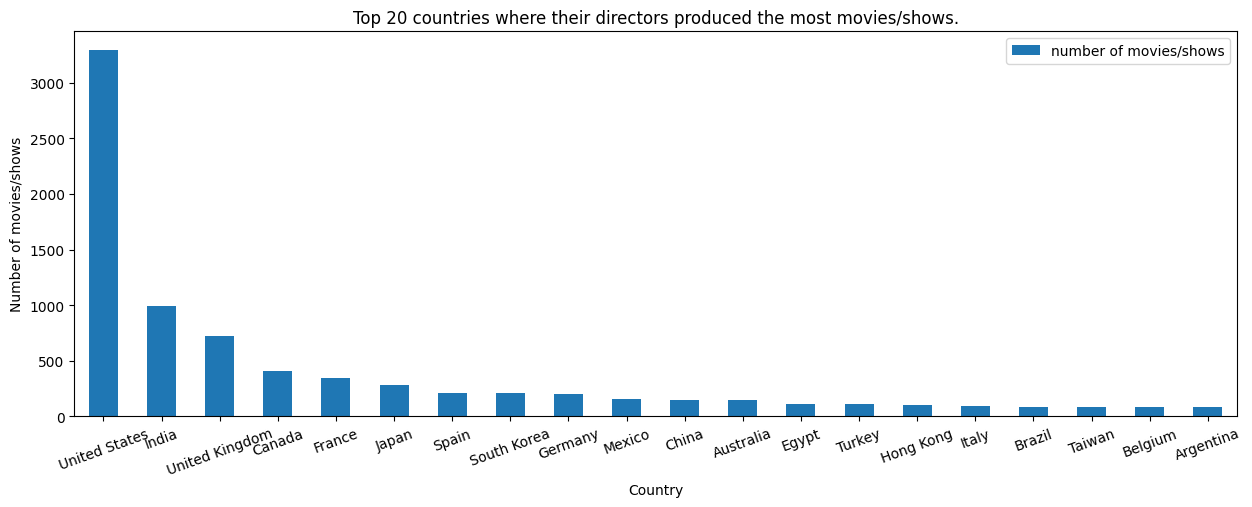

In [15]:
'''
Utility function that:
> Explodes a specific column's fields to multiple individual rows
> Cleans any whitespace and '\n' from a specific column's fields  
'''
def clean_explode(df, column):
    df[column] = df[column].str.strip().str.split(',')
    df = df.explode(column)
    df[column] = df[column].apply(lambda x: str(x).strip())
    df = df.reset_index(drop=True)
    return df

top_n = 20
# Select only the directors and the show ids
directors = nx_df[['director', 'show_id']]
# Cleanup
directors.dropna(inplace=True)
directors = directors.reset_index(drop=True)

directors = clean_explode(directors, 'director')
# Count for each director, the number of shows he has produced
directors = pd.DataFrame(directors.groupby(by=['director']).count()).reset_index()
directors.columns = ['director', 'count']
directors.sort_values(by='count', ascending=False, inplace=True)

# Plot top N results
directors.head(top_n).plot(x='director', y='count', kind='bar', xlabel='Directors', ylabel='Number of Movies/Shows', 
                           figsize=[15, 5], legend=False, title=f'Top {top_n} directors with the most movies/shows.')

plt.xticks(rotation = 60)

directors.tail(top_n).plot(x='director', y='count', kind='bar', xlabel='Directors', ylabel='Number of Movies/Shows', 
                           figsize=[15, 5], legend=False, title=f'Top {top_n} directors with the least movies/shows.')

plt.xticks(rotation = 60)

# Select only the directors and the countries
dir_per_countr = nx_df[['country', 'director']]
# Cleanup
dir_per_countr.dropna(inplace=True)
dir_per_countr.reset_index(drop=True, inplace=True)

dir_per_countr = clean_explode(dir_per_countr, 'country')
dir_per_countr = clean_explode(dir_per_countr, 'director')

# Count the number of directors in each country
dir_per_countr = pd.DataFrame(dir_per_countr.groupby(by=['country']).count()).reset_index()
dir_per_countr.columns = ['country', 'directors per country']
# Cleanup
dir_per_countr = dir_per_countr.replace(to_replace='', value=float('NaN'))
dir_per_countr.dropna(inplace=True)
dir_per_countr.sort_values(by='directors per country', ascending=False, inplace=True)

# Plot top N results
dir_per_countr.head(top_n).plot(x='country', y='directors per country', kind='bar', xlabel='Country', ylabel='Number of directors',
        figsize=[15, 5], title=f'Top {top_n} countries with the most directors.')

plt.xticks(rotation=20)

# Collect the total number of movies/shows produced by a specific country's directors
prod_per_dirs = nx_df[['country', 'show_id']]
prod_per_dirs.dropna(inplace=True)
prod_per_dirs.reset_index(drop=True, inplace=True)

prod_per_dirs = clean_explode(prod_per_dirs, 'country')

prod_per_dirs = pd.DataFrame(prod_per_dirs.groupby(by=['country']).count()).reset_index()
prod_per_dirs.columns = ['country', 'number of movies/shows']

prod_per_dirs = prod_per_dirs.replace(to_replace='', value=float('NaN'))
prod_per_dirs.dropna(inplace=True)
prod_per_dirs.sort_values(by='number of movies/shows', ascending=False, inplace=True)

# Plot top N results
prod_per_dirs.head(top_n).plot(x='country', y='number of movies/shows', kind='bar', xlabel='Country', ylabel='Number of movies/shows',
        figsize=[15, 5], title=f'Top {top_n} countries where their directors produced the most movies/shows.')

plt.xticks(rotation=20)

### Query 10.
*Study the TV series and draw a graph representing them according to the number of seasons.*

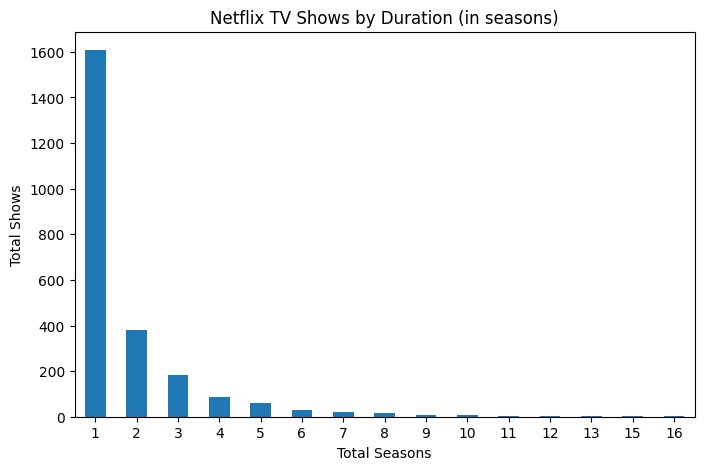

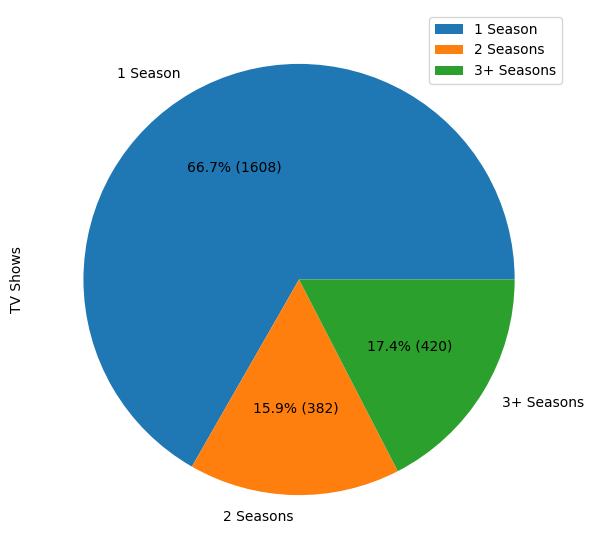

In [16]:
def categorize_series(duration):
  if duration >= 3:
    return '3+ Seasons'
  sufix = ''
  if duration == 2:
    sufix = 's'
  return str(duration) + ' Season' + sufix
  

def shows_per_seasons():
  show_info = nx_df[['type', 'duration']].where(nx_df['type'] == 'TV Show').dropna()
  # Transform 'duration' to indicate the number (int) of seasons for each show 
  show_info['duration'] = show_info.apply(lambda row : int(str(row.duration).strip().split()[0]), axis=1)
  # Group by the Number of Seasons
  show_info = show_info.groupby(by=['duration']).count()
  show_info = show_info.sort_values(by=['duration'])
  show_info.rename({'type' : 'TV Shows'}, axis=1, inplace=True)
  show_info.plot(kind='bar', width=0.5, xlabel='Total Seasons', legend=False, figsize = (8, 5),
                          ylabel='Total Shows', title='Netflix TV Shows by Duration (in seasons)')
  plt.xticks(rotation=0)
  plt.show()
  print()

  # Exhibit the distribution among 1, 2, 3+ Seasons shows
  show_info = show_info.reset_index()
  show_info['duration'] = show_info.apply(lambda row : categorize_series(row.duration), axis=1)
  show_info = show_info.groupby(by=['duration']).sum()
  total_shows = show_info['TV Shows'].sum()
  show_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_shows))
  plt.show()

shows_per_seasons()

We notice that the vast majority of Netflix series consist of 1 season series. Series with 1 season are about 4 times more than series with 2 seasons, which in turn are about twice as long as series with 3 seasons. The longest running series on Netflix is 16 seasons long.

### Query 11.
*Utilize all of the provided files to answer the following question: Which are the highest rated movies? You will need to properly combine the provided files, in order to keep only the Netflix movies for which there are available IMBD ratings.*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Pulp Fiction'),
  Text(1, 0, "Schindler's List"),
  Text(2, 0, 'Inception'),
  Text(3, 0, 'Ani... Dr. Kashinath Ghanekar'),
  Text(4, 0, 'City of God'),
  Text(5, 0, 'Much Ado About Nothing'),
  Text(6, 0, 'Gol Maal'),
  Text(7, 0, 'Koshish'),
  Text(8, 0, 'Oththa Seruppu Size 7'),
  Text(9, 0, 'Eh Janam Tumhare Lekhe'),
  Text(10, 0, 'Mallesham'),
  Text(11, 0, 'Merku Thodarchi Malai'),
  Text(12, 0, 'Manto'),
  Text(13, 0, 'Black Friday'),
  Text(14, 0, 'Joker')])

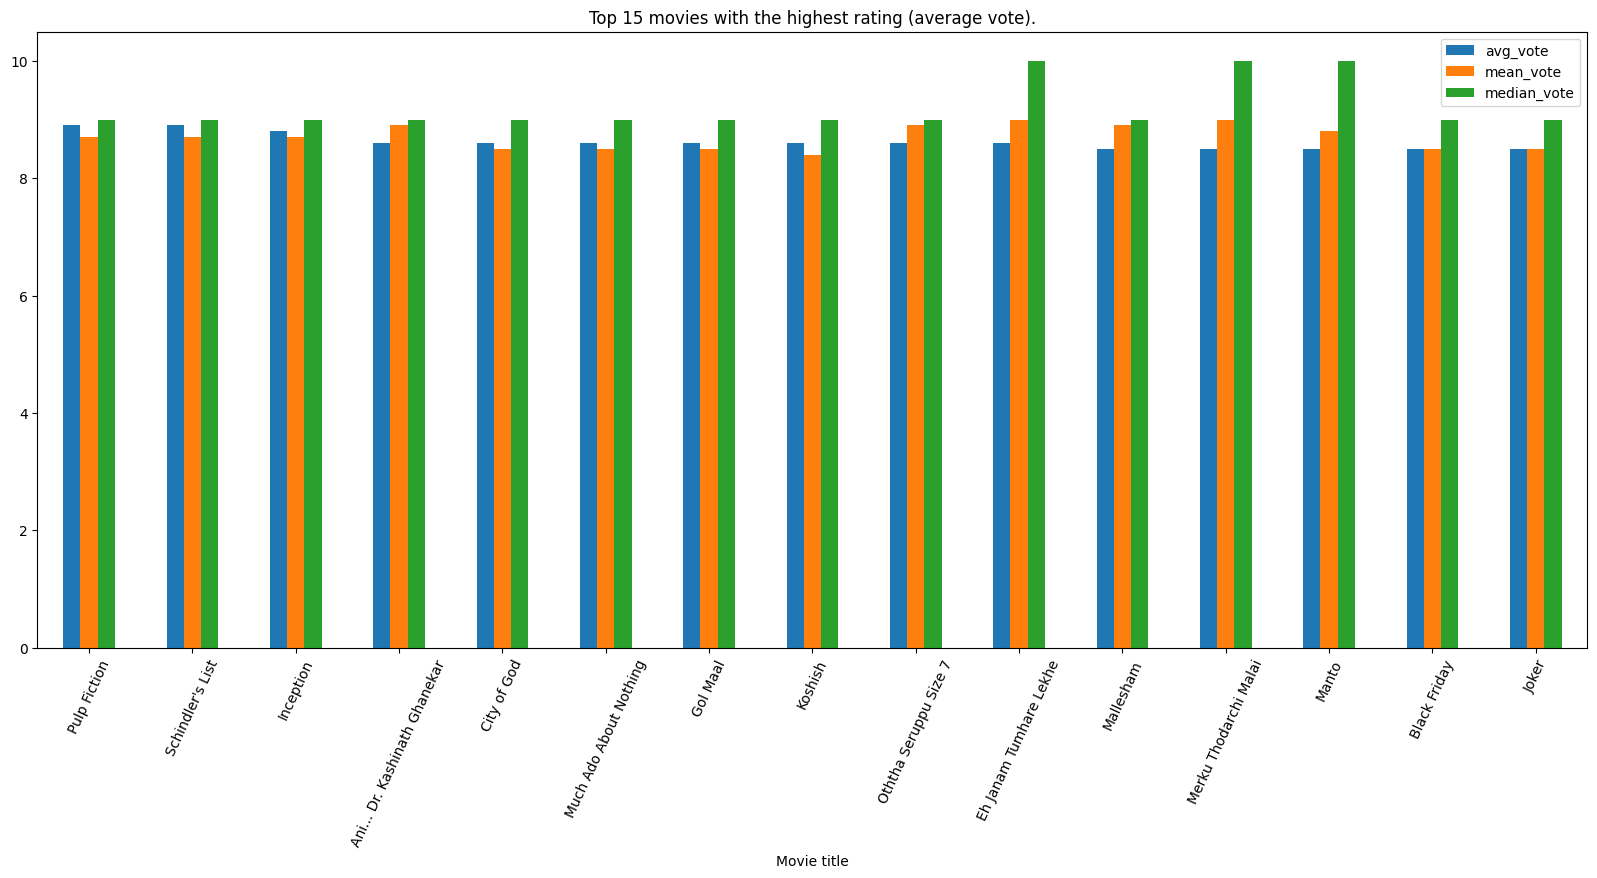

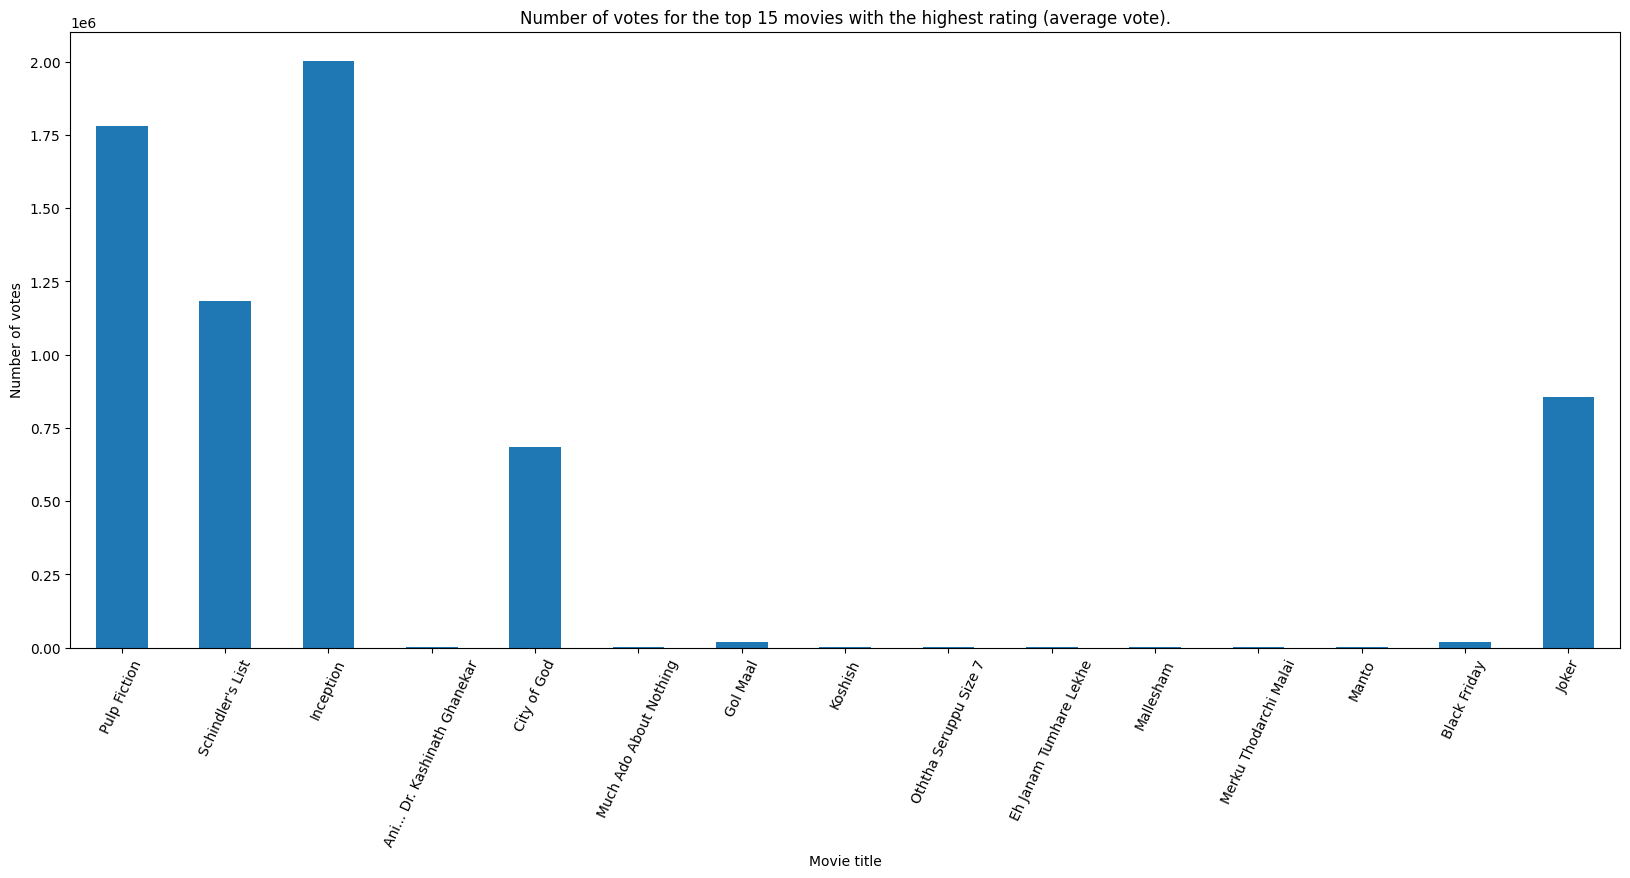

In [17]:
# Collect all movies from netflix
netfx = nx_df[['title']].where(nx_df['type'] == 'Movie').dropna()
# Collect id, mean and median vote from IMDb ratings
imdb_ratings = imdb_r_df[['imdb_title_id', 'mean_vote', 'median_vote']].dropna()
# Collect id, title, average vote and total votes from IMDb movies
imdb_mov = imdb_m_df[['imdb_title_id', 'title', 'avg_vote', 'votes']].dropna()

# Join the 2 IMDb dataframes together, on movie id
imdb = imdb_ratings.join(imdb_mov.set_index('imdb_title_id'), on='imdb_title_id')

# Join (inner) the previous dataframe with the netflix movies on title
info = imdb.join(netfx.set_index('title'), on='title', how='inner')
info.reset_index(drop=True, inplace=True)

# Sort the final dataframe based on the average vote
info = info.drop(columns='imdb_title_id').sort_values(by='avg_vote', ascending=False)

# Plot the results
top_n = 15
info.head(top_n).plot(x='title', y=['avg_vote', 'mean_vote', 'median_vote'], kind='bar', xlabel='Movie title', 
        figsize=[20, 8], title=f'Top {top_n} movies with the highest rating (average vote).')

plt.xticks(rotation=65)

info.head(top_n).plot(x='title', y='votes', kind='bar', xlabel='Movie title', ylabel='Number of votes', label=False,
        figsize=[20, 8], title=f'Number of votes for the top {top_n} movies with the highest rating (average vote).', legend=False)

plt.xticks(rotation=65)

## 2. Recommendation system

### Initialization of the appropriate functions and containers
To begin with, each title and description, once used in the extraction of suggested films, should be channeled into a lemmatization process, in order to retain only the common roots of the words that make them up. Thus, the *spaCy* library was selected for the lemmatization process, while the *NLTK* library was selected as a stopwords container.

In [18]:
import pandas as pd
# Import the appropriate vectorizers (CountVect., and TF-IDF Vect.)
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect

# Use an advanced stopword container via NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Import spacy for the lemmatization process
import spacy
nlp = spacy.load('en_core_web_sm')

# Function to return a list of lemmas (without punctuation and pronouns)
lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.is_punct]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# First of all, lemmatise all of the titles and descriptions
nx_df_lem = nx_df.copy()
nx_df_lem['description'] = nx_df_lem['description'].apply(lambda x: " ".join(lemmatok(x)))
nx_df_lem['title'] = nx_df_lem['title'].apply(lambda x: " ".join(lemmatok(x)))

# Extract descriptions and titles and merge them into individual strings
desc_l = nx_df_lem['description'].to_list()
title_l = nx_df_lem['title'].to_list()
desc_titles = [( desc_l[i] + ' ' + title_l[i] ) for i in range(len(desc_l))]

### 1.a - Boolean Bag of Words (BoW)

In [28]:
# BoW

# Declare vectorizers (unigram, bigram)
cv_uni = cvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=5, max_df=0.96, max_features=3000, binary=True)
cv_bi = cvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2, binary=True)
cv_unibi = cvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000, binary=True)

# Transform 
cv_tr_u = cv_uni.fit_transform(desc_titles)
cv_tr_b = cv_bi.fit_transform(desc_titles)
cv_tr_ub = cv_unibi.fit_transform(desc_titles)

# Create the respective dataframes

# DataFrame consisting of unigrams
cv_u_df = pd.DataFrame(cv_tr_u.toarray(), columns = cv_uni.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
cv_b_df = pd.DataFrame(cv_tr_b.toarray(), columns = cv_bi.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
cv_df = pd.DataFrame(cv_tr_ub.toarray(), columns = cv_unibi.get_feature_names_out(), index= nx_df_lem['show_id'])

### 1.b - Term Frequency - Inverse Document Frequency (TF-IDF)

In [30]:
# TF-IDF

# Declare vectorizers (unigram, bigram)
tf_uni = tfvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=2, max_df=0.96, max_features=3000)
tf_bi = tfvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2)
tf_unibi = tfvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000)

# Transform 
tf_tr_u = tf_uni.fit_transform(desc_titles)
tf_tr_b = tf_bi.fit_transform(desc_titles)
tf_tr_ub = tf_unibi.fit_transform(desc_titles)

# Create the respective dataframes

# DataFrame consisting of unigrams
tf_u_df = pd.DataFrame(tf_tr_u.toarray(), columns = tf_uni.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
tf_b_df = pd.DataFrame(tf_tr_b.toarray(), columns = tf_bi.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
tf_df = pd.DataFrame(tf_tr_ub.toarray(), columns = tf_unibi.get_feature_names_out(), index= nx_df_lem['show_id'])

**Notes:** Regarding the tuning of `min_df`, `max_df` and `max_features` parameters when declaring the vectorizers, the values were given through multiple experiments in order to satisfy all of the following at the same time:
1. Satisfactory performance of the trained models in the requested questions.
2. Training time of the models within logical boundaries.
3. Model training without consuming all the offered Google Colab RAM.

### 2. Function inclusion

In order to calculate the representations based on Jaccard-Tanimoto and cosine similarity methods, cdist() function from the sciPy library has been included, which calculates the distance between its two inputs based on a metric. In this exercise, the metrics that will be used are 'jaccard' and 'cosine'.

In [31]:
from scipy.spatial.distance import cdist

#### Similarity calculation function
The following `similar()` function, encapsulates the `cdist()`, fully serving the requirements of this project.

In [32]:
'''
Receives two dataframes, df1, df2 and a metric

Computes the distance between each pair of the two collections of inputs.

Returns a 2D list
'''
def similar(df1, df2, metric):
    return 1-cdist(df1, df2, metric)

### 2.a 
#### Utilization of `similar()` method with the `jaccard metric` for the calculation of the similarity of films with the Jaccard-Tanimoto method given their feature vectors.


In [ ]:
# BoW - unigram
cv_uni_sim = similar(cv_u_df, cv_u_df, 'jaccard')
# BoW - bigram
cv_bi_sim = similar(cv_b_df, cv_b_df, 'jaccard')
# BoW unigram & bigram
cv_sim = similar(cv_df, cv_df, 'jaccard')

### 2.b
#### Utilization of `similar()` with the *cosine* metric for the calculation of the similarity of films with the Cosine Similarity method given their feature vectors.

In [ ]:
# TF-IDF - unigram
tf_uni_sim = similar(tf_u_df, tf_u_df, 'cosine')
# TF-IDF - bigram
tf_bi_sim = similar(tf_b_df, tf_b_df, 'cosine')
# TF-IDF unigram & bigram
tf_sim = similar(tf_df, tf_df, 'cosine')

#### Dictionary creation process
The following code cell includes the function that converts the output (2D array) of the `similar()` process into a dictionary, which presents for each movie in the dataset its 100 most similar movies. The keys that make it up are show ids (e.g s123), while the corresponding values are lists of tuples. Each tuple consists of two fields: 
1. The first field is a decimal number (similarity estimate by the Jaccard-Tanimoto or Cosine Similarity method). 
2. The second field is a show id.

In [ ]:
def dict_prep(l):
    d = {}
    # Form the keys
    for i in range(len(l)):
        idx = 's' + str(i+1) 
        d[idx] = l[i]

    # Form the respective tuples, sort them and keep top 100
    for j, key in enumerate(d):
        l = list(d[key])
        d[key] = [(l[i], 's' + str(i+1)) for i in range(len(l))]
        d[key] = [k for k in d[key] if k[1] != key]
        d[key].sort(reverse=True)
        d[key] = d[key][:100]

    return d

#### Finishing touches
After the call of `similar()` function **for each** of the generated DataFrames, the corresponding dictionaries are structured, in order to quickly extract the requested information.

In [ ]:
# Form all the necessary dictionaries
cv_uni_sim = dict_prep(cv_uni_sim) 
cv_bi_sim = dict_prep(cv_bi_sim) 
cv_sim = dict_prep(cv_sim) 

tf_uni_sim = dict_prep(tf_uni_sim) 
tf_bi_sim = dict_prep(tf_bi_sim) 
tf_sim = dict_prep(tf_sim) 

In [ ]:
# Function for stat printing
def pretty_print(l, title, N):
    print(f'Top {N} recommended productions for "{title}":')
    print('-----------------------------------------------')
    print('INDEX -- TITLE -- SIMILARITY')
    for i, (est, t) in enumerate(l):
        print(f'{i+1}. -- {t} -- {str(est)[:4]}')

### 3. Title-based prediction.
`get_similar_movies1()` function receives the title of a movie, a number `N`, a method and an `ngram` tuple. The previous function is able to fully respond to any input, returning the top N recommended movies, based on the similarity and depending on the title entered. The extraction of the information is based entirely on the 6 trained dictionaries.

In [ ]:
'''
Receives a movie title, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given movie title

If "method" is "boolean", the information is being extracted from the BoW method's trained dataset
If "method" is "tf-idf", the information is being extracted from the TF-IDF method's trained dataset

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies1(movie_title, N=10, method='boolean', ngram=(1, 2)):
    # Try and fetch the given title's show id
    try:
        id = nx_df[nx_df['title'] == movie_title]['show_id'].values[0]
    except:
        print(f'Error, "{movie_title}" does not exist in the database.')
        return None

    sims = None
    # Boolean method
    if method == 'boolean':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = cv_uni_sim[id] if ngram==(1, 1) else cv_sim[id] if ngram==(1, 2)  \
                else cv_bi_sim[id] if ngram==(2, 2) else None

        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        # Keep only the top "N" movies
        sims = sdata[:N]

    # TF-IDF method
    elif method == 'tf-idf':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = tf_uni_sim[id] if ngram==(1, 1) else tf_sim[id] if ngram==(1, 2)  \
                else tf_bi_sim[id] if ngram==(2, 2) else None
        
        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        sims = sdata[:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None
    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]

#### Results demonstration
`get_similar_movies1()` function is being run for any possible (and valid) input, with the number of the desired recommended movies equal to 10 and the given movie titles to `Surviving Escobar - Alias JJ` and `Last Breath`.

In [ ]:
N = 10
mtitle = 'Surviving Escobar - Alias JJ'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)

mtitle = 'Last Breath'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)

### Remarks and Conclusions

#### **BoW**
Although the boolean BoW array model of the unigrams is very understandable and easy to implement, it is very sparse and does not take into account the order in which the words appear in the text. In addition, the BoW table of bigrams gathers more content, as it can take into account the order of the words in pairs, but this does not limit this table from being too sparse and not gathering a sufficient amount of information for exporting reliable results.

#### **TF-IDF**
The models of the TF-IDF array of unigrams and bigrams are similar to those of the BoW model, with the significant (and positive) difference that the quantity that is being calculated, expresses whether a word or a pair of words (unigrams or bigrams respectively) is rare among all the files. However, the information (especially in bigrams) is sparsely distributed and in many places insufficient to draw conclusions.

### 4. Prediction based on description / keywords.
`get_similar_movies2()` function receives a description, a number `N`, a method and an `ngram` tuple.  The previous function is able to fully respond to any input, returning the top N recommended movies, based on the similarity and depending on the title entered. The extraction of the information is based entirely on the 6 trained dictionaries.

In [ ]:
'''
Receives a description, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given keywords/description

If "method" is "boolean", the information is being trained with BoW method
If "method" is "tf-idf", the information is being trained with TF-IDF method

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies2(descr, N=10, method='tf-idf', ngram=(1, 2)):
    
    dsc = descr
    # Lemmatise the given description
    descr = " ".join(lemmatok(descr))
    # Add the given description to the dataset
    descriptions = nx_df_lem['description'].to_list() + [descr]
    # Add an index for the user's input description
    new_indices = nx_df_lem['show_id'].append(pd.Series(['User arg']))

    # Transform all the existing descriptions along with the user's input and create 
    # the appropriate DataFrames (based on the provided method & ngram)
    sims = None
    # Boolean method
    if method == 'boolean':
        df = None
        if ngram==(1, 2):
            tr_ub = cv_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = cv_unibi.get_feature_names(), index=new_indices)
        
        elif ngram==(1, 1):
            tr_u = cv_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = cv_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = cv_bi.fit_transform(descriptions)
            df = pd.DataFrame(tr_b.toarray(), columns = cv_bi.get_feature_names(), index=new_indices)
        
        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None

        # Keep a dataframe consisting only of the user's input feature vector 
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'jaccard'))
        sims = list(sdata.values())[0][:N]

    elif method == 'tf-idf':
        df = None
        if ngram==(1, 2):
            tr_ub = tf_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = tf_unibi.get_feature_names(), index=new_indices)

        elif ngram==(1, 1):
            tr_u = tf_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = tf_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = tf_bi.fit_transform(descriptions)    
            df = pd.DataFrame(tr_b.toarray(), columns = tf_bi.get_feature_names(), index=new_indices)

        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None
        
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'cosine'))
        sims = list(sdata.values())[0][:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None

    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]

#### Results demonstration
`get_similar_movies2()` function is being run for any possible (and valid) input, with the number of the desired recommended movies equal to 10 and the given descriptions to `Love story of teenagers at high school` and `Psycological thriller with psychic patients`.

In [ ]:
N = 10
dsc = 'Love story of teenagers at high school'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)


dsc = 'Psycological thriller with psychic patients'
print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)

### Possible failure reasons
There are several reasons why models may fail to produce a reasonable estimation based on a description provided. For example, the word *break* may mean the break up of a couple, a broken bone or even a short break. The algorithms implemented above are not able to separate the true meanings to such an extent and as a result they produce quite inaccurate results. Another example that leads to misleading results is the existence of multiple words synonymous to each other and not their grouping into one word that is semantically equivalent. For example, the words *Group, Clique, Gang, Club* may be scattered throughout a text and actually convey the same meaning, but without being grouped *intelligently* where necessary, altering the meaning of certain descriptions. Finally, a very common reason for failure is the insufficient amount of information in the dataset, with the result that some suggested films belong to a completely different genre than the original film.


T H E   
E N D